In [30]:
import folium
import pandas as pd
import h3
from shapely.geometry import Polygon, Point
import shapely.wkt
from geojson import Point, Feature, FeatureCollection, dump
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Create a GeoJson

### First find all used hexagons

In [27]:
#Get this file from scibo
df = pd.read_csv('sharenow_supply_data_6mo.csv')

df_StartEnd = df[['hex_start_7','hex_end_7']]

list_StartUnique = list(df['hex_start_7'].unique())
list_EndUnique = list(df['hex_end_7'].unique())
list_UniqueHexs = list(pd.Series(list_StartUnique+list_EndUnique).unique())

### Now get the cornerstones

In [ ]:
def output_h3_id_attributes(h3_id):
    return Polygon(h3.h3_to_geo_boundary(h3_id, geo_json=True))

In [4]:
features = []
for hexID in list_UniqueHexs:
    features.append(Feature(geometry=output_h3_id_attributes(hexID), properties={"hexID": hexID}))

feature_collection = FeatureCollection(features)

with open('berlin_charger.geojson', 'w') as f:
   dump(feature_collection, f)

# Visulise

In [5]:
map = folium.Map(location=[52.518839, 13.399304], default_zoom_start=30)

In [6]:
chargerPerHex = pd.read_csv('charger_in_hex.csv')
finalData = chargerPerHex[['hexID']]
chargerPerHex = chargerPerHex[['x1','x2','x3']].sum(axis=1)
finalData['charger'] = chargerPerHex

In [7]:
#Avoid black points 
#Get all hex ids

for id in list_StartUnique:
    if id not in finalData['hexID'].unique():
        finalData = finalData.append({'hexID':id,'charger':0},ignore_index=True)

In [8]:
map.choropleth(geo_data="berlin_charger.geojson",
             data=finalData, 
             columns=['hexID', 'charger'], 
             key_on='feature.properties.hexID', 
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Charger')
map

## Sensitivities

In [9]:
plt.style.use('seaborn')
figsize = (16,9)

### Beta

In [90]:
path = "./sensitivity/beta/"
df_charger_beta = pd.DataFrame()
df_E_not_supplied_beta = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_beta["beta_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_beta["beta_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_beta = pd.read_csv((path+file))
        df_cost_beta.columns = ["Beta", "Total Cost"]
        df_cost_beta.set_index("Beta", inplace=True)
        df_cost_beta.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_beta = pd.read_csv((path+file))
        df_cvar_beta.columns = ["Beta", "cvar"]
        df_cvar_beta.set_index("Beta", inplace=True)
        df_cvar_beta.sort_index(inplace=True)

In [88]:
data = []
df_charger_beta = df_charger_beta.T.reset_index()


for row in df_charger_beta.values:
    for i,charger_type in enumerate(["3 kW", "7 kW", "11 kW"]):
        data.append([row[0],row[i+1],charger_type])

df_charger_beta = pd.DataFrame(data,columns=['beta','charger','type'])

Text(0.5, 1.0, 'Number of chargers installed')

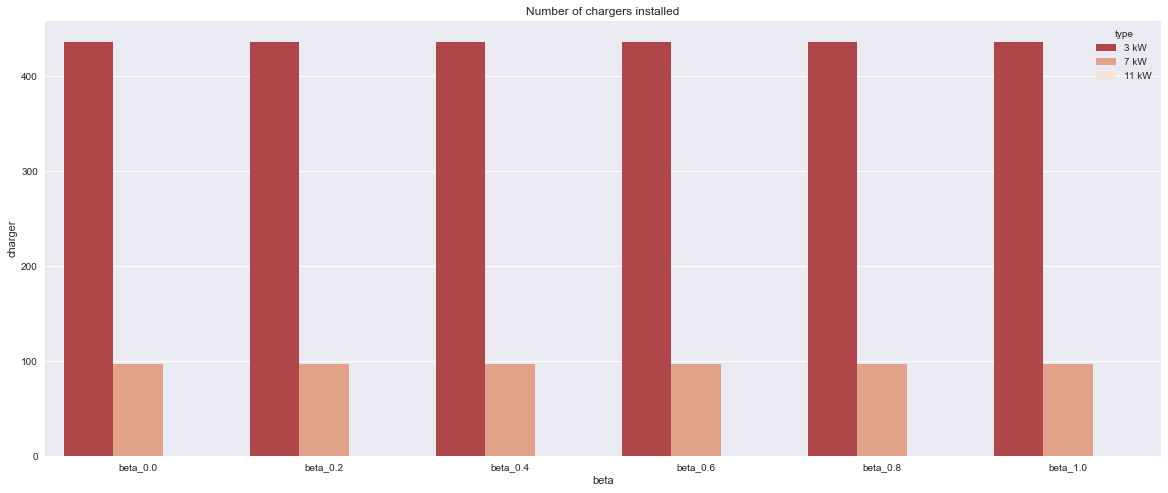

In [84]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=df_charger_beta,x='beta',y='charger',hue='type',palette=sns.color_palette("RdBu", )).set_title("Number of chargers installed")

Text(0.5, 1.0, 'Number of chargers installed')

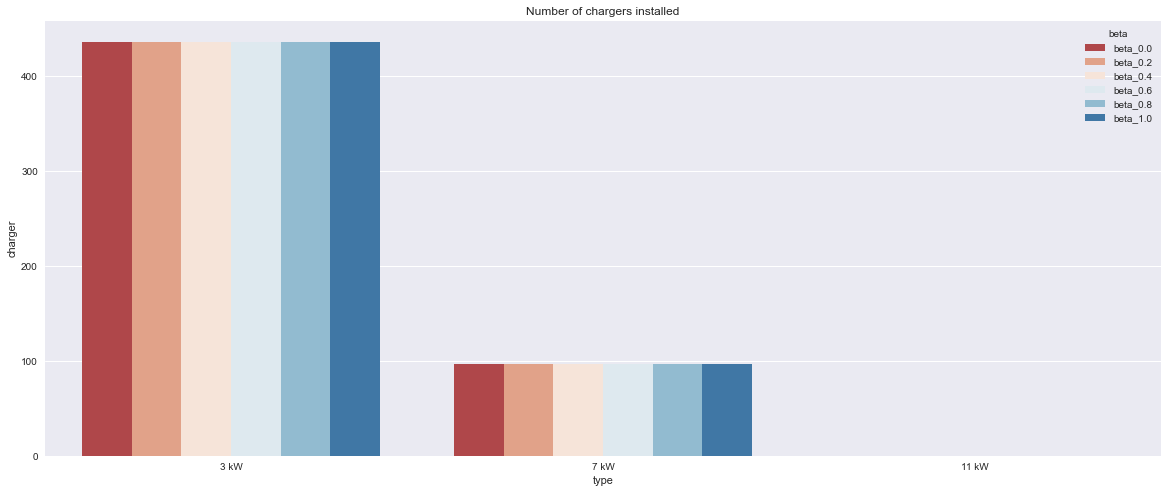

In [85]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=df_charger_beta,x='type',y='charger',hue='beta',palette=sns.color_palette("RdBu", 7)).set_title("Number of chargers installed")

<AxesSubplot:title={'center':'Energy not supplied'}>

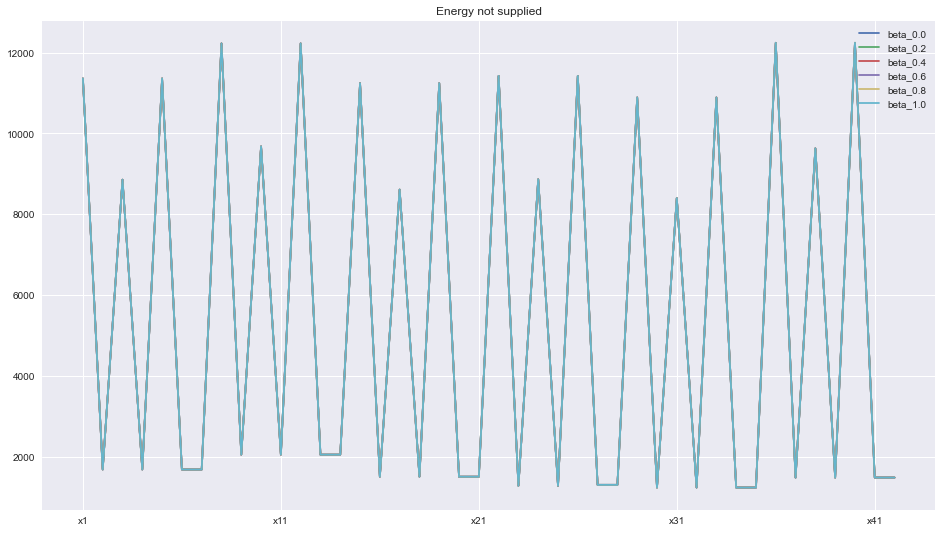

In [13]:
df_E_not_supplied_beta.plot(title="Energy not supplied", figsize = figsize)

<AxesSubplot:title={'center':'Total cost'}, xlabel='Beta'>

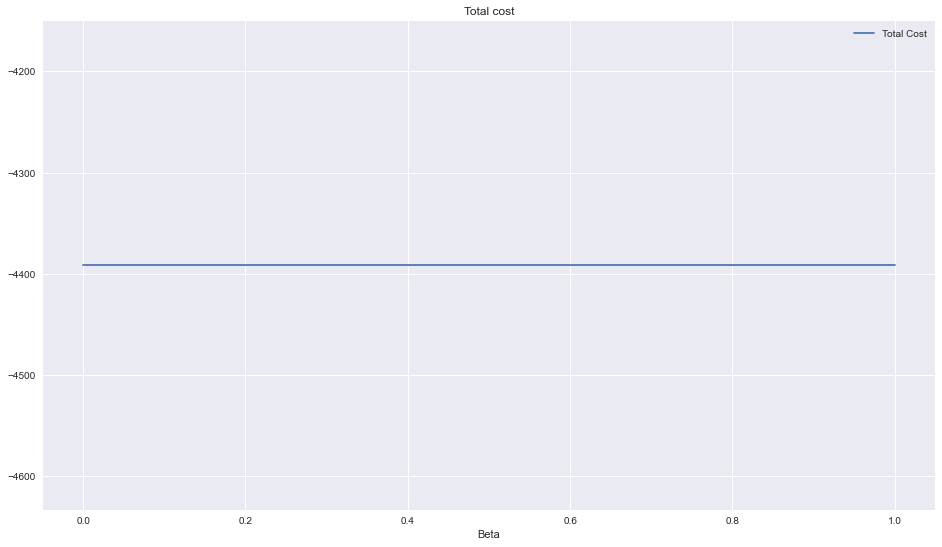

In [14]:
df_cost_beta.plot(title="Total cost", figsize = figsize)

<AxesSubplot:title={'center':'cvar'}, xlabel='Beta'>

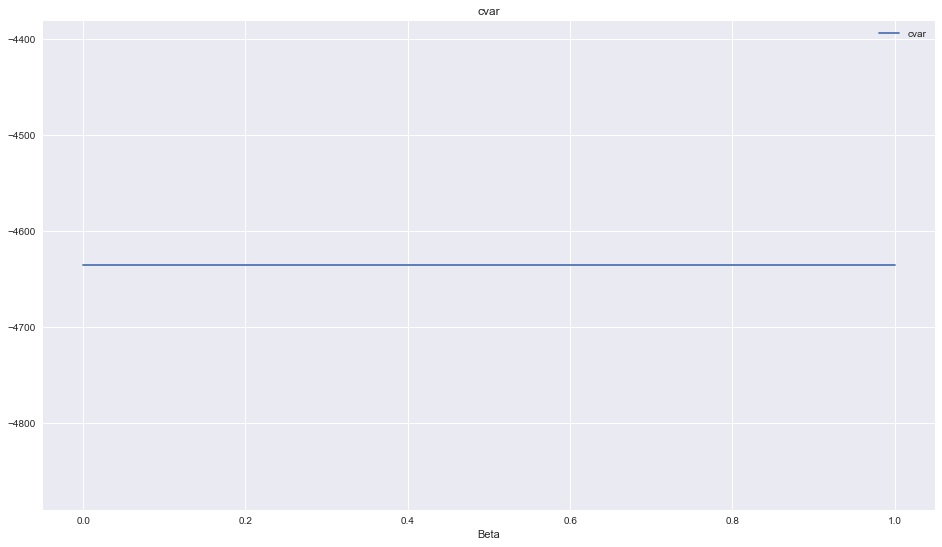

In [15]:
df_cvar_beta.plot(title="cvar", figsize = figsize)

## Opportunity Cost

In [137]:
path = "./sensitivity/opportunity/"
df_charger_opc = pd.DataFrame()
df_E_not_supplied_opc = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_opc["op_cost_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_opc["op_cost_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_opc = pd.read_csv((path+file))
        df_cost_opc.columns = ["Opportunity Cost", "Total Cost"]
        df_cost_opc.set_index("Opportunity Cost", inplace=True)
        df_cost_opc.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_opc = pd.read_csv((path+file))
        df_cvar_opc.columns = ["Opportunity Cost", "cvar"]
        df_cvar_opc.set_index("Opportunity Cost", inplace=True)
        df_cvar_opc.sort_index(inplace=True)

In [138]:
data = []
df_charger_opc = df_charger_opc.T.reset_index()


for row in df_charger_opc.values:
    for i,charger_type in enumerate(["3 kW", "7 kW", "11 kW"]):
        data.append([row[0],row[i+1],charger_type])

df_charger_opc = pd.DataFrame(data,columns=['op_cost','charger','type'])

Text(0.5, 1.0, 'Number of chargers installed')

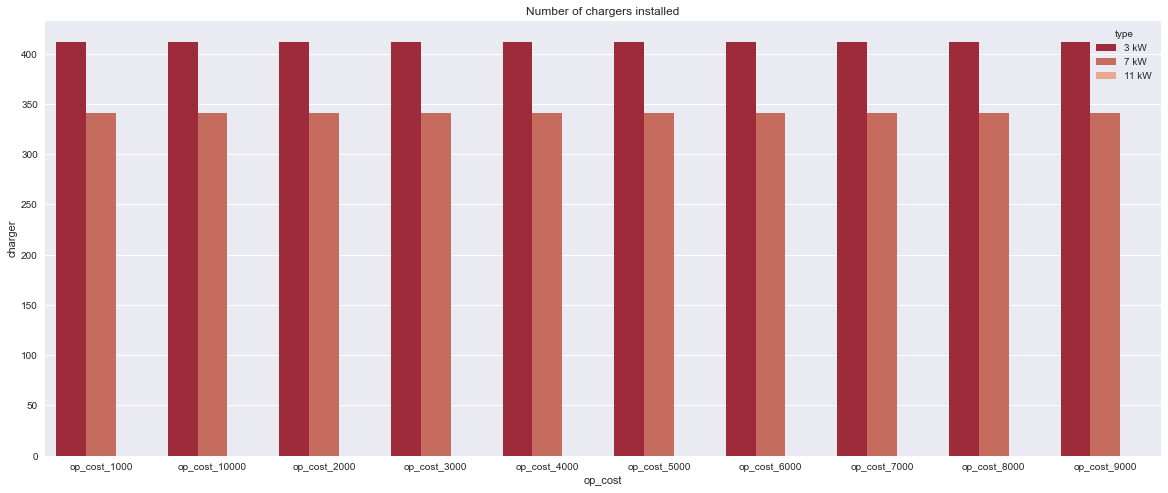

In [139]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=df_charger_opc,x='op_cost',y='charger',hue='type',palette=sns.color_palette("RdBu", 9)).set_title("Number of chargers installed")

Text(0.5, 1.0, 'Number of chargers installed')

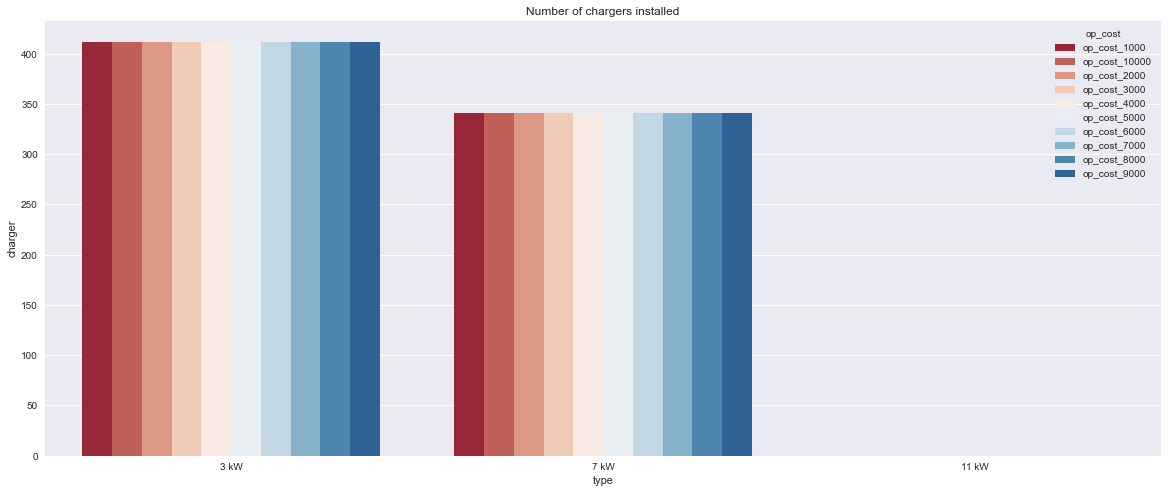

In [140]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=df_charger_opc,x='type',y='charger',hue='op_cost',palette=sns.color_palette("RdBu", 10)).set_title("Number of chargers installed")

<AxesSubplot:title={'center':'Energy not supplied'}>

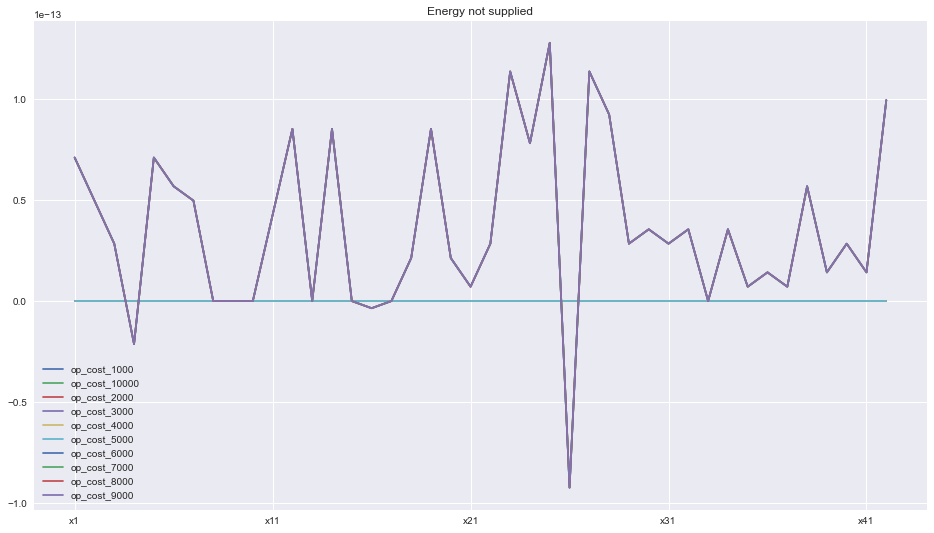

In [18]:
df_E_not_supplied_opc.plot(title="Energy not supplied", figsize = figsize)

<AxesSubplot:title={'center':'Total cost'}, xlabel='Opportunity Cost'>

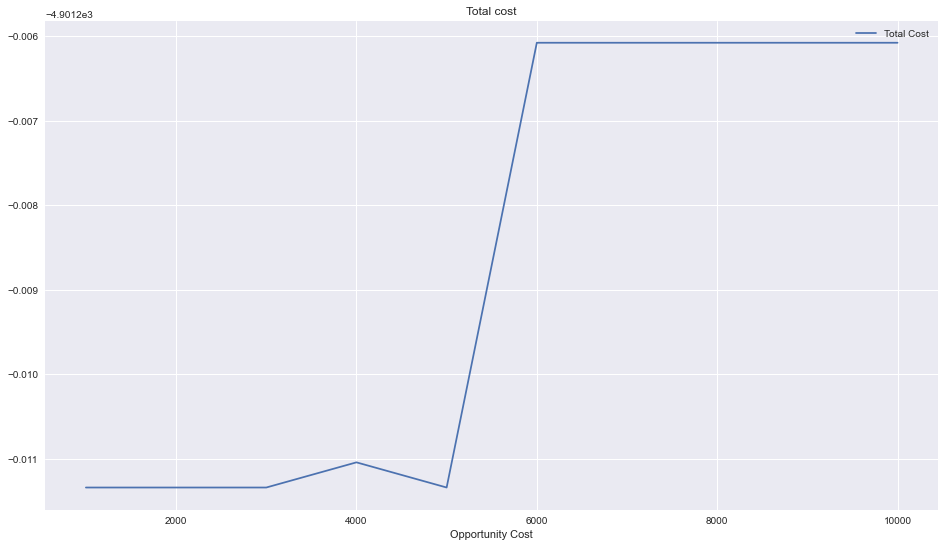

In [19]:
df_cost_opc.plot(title="Total cost", figsize = figsize)

<AxesSubplot:title={'center':'Cvar'}, xlabel='Opportunity Cost'>

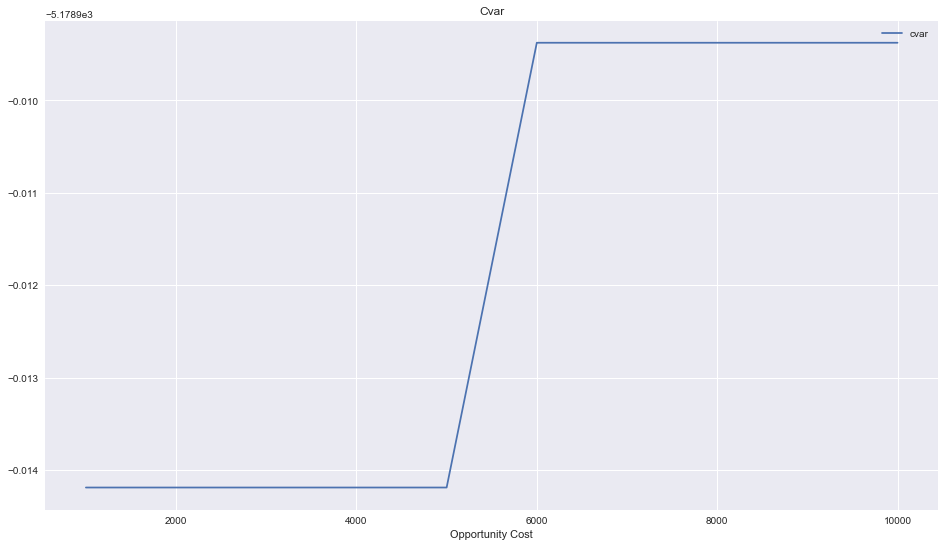

In [20]:
df_cvar_opc.plot(title="Cvar", figsize = figsize)

## Charging hours

In [153]:
path = "./sensitivity/hours/"
df_charger_hours = pd.DataFrame()
df_E_not_supplied_hours = pd.DataFrame()

for file in os.listdir(path):
    if "charger" in file:
        df_charger_hours["hours_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "E_not_supplied" in file:
        df_E_not_supplied_hours["hours_"+file.split("_")[-1].split(".c")[0]] = \
            pd.read_csv((path+file)).sum()

    elif "cost_dict" in file:
        df_cost_hours = pd.read_csv((path+file))
        df_cost_hours.columns = ["Hours for charging", "Total Cost"]
        df_cost_hours.set_index("Hours for charging", inplace=True)
        df_cost_hours.sort_index(inplace=True)
        
    elif "cvar_dict" in file:
        df_cvar_hours = pd.read_csv((path+file))
        df_cvar_hours.columns = ["Hours for charging", "cvar"]
        df_cvar_hours.set_index("Hours for charging", inplace=True)
        df_cvar_hours.sort_index(inplace=True)

In [154]:
data = []
df_charger_hours = df_charger_hours.T.reset_index()


for row in df_charger_hours.values:
    for i,charger_type in enumerate(["3 kW", "7 kW", "11 kW"]):
        data.append([row[0],row[i+1],charger_type])

df_charger_hours = pd.DataFrame(data,columns=['hours','charger','type'])

Text(0.5, 1.0, 'Number of chargers installed')

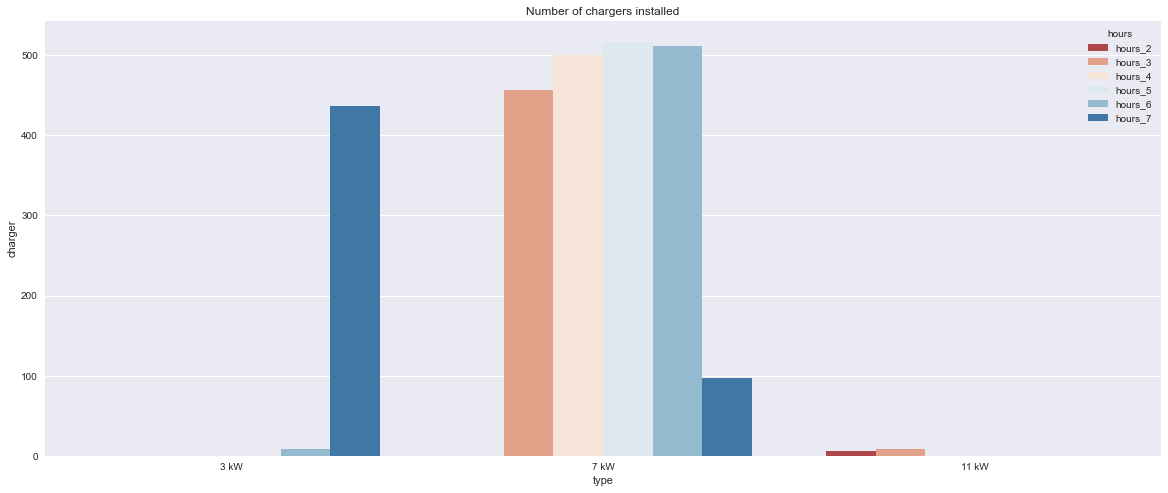

In [155]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=df_charger_hours,x='type',y='charger',hue='hours',palette=sns.color_palette("RdBu", 6)).set_title("Number of chargers installed")

Text(0.5, 1.0, 'Number of chargers installed')

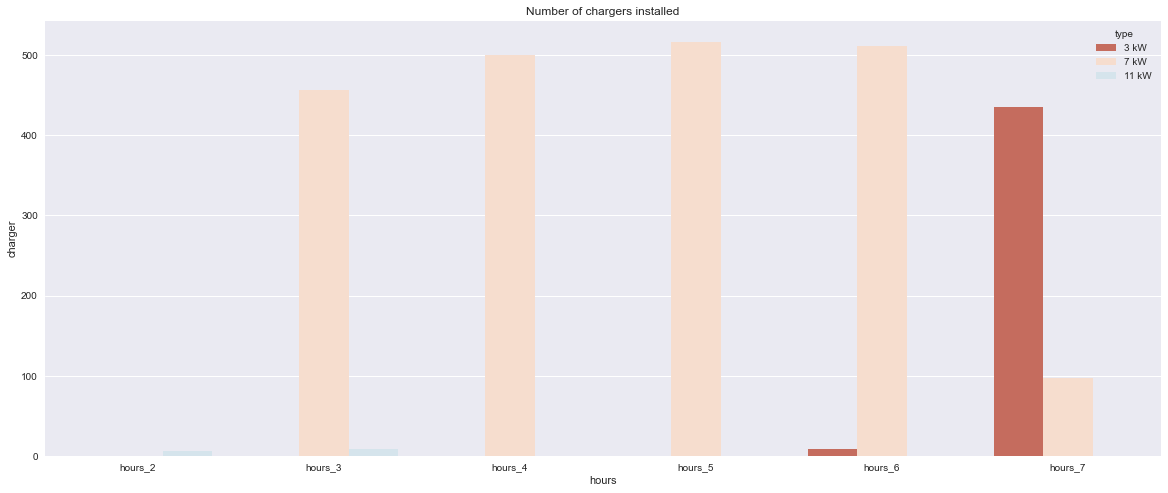

In [156]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(data=df_charger_hours,x='hours',y='charger',hue='type',palette=sns.color_palette("RdBu", 4)).set_title("Number of chargers installed")

<AxesSubplot:title={'center':'Energy not supplied'}>

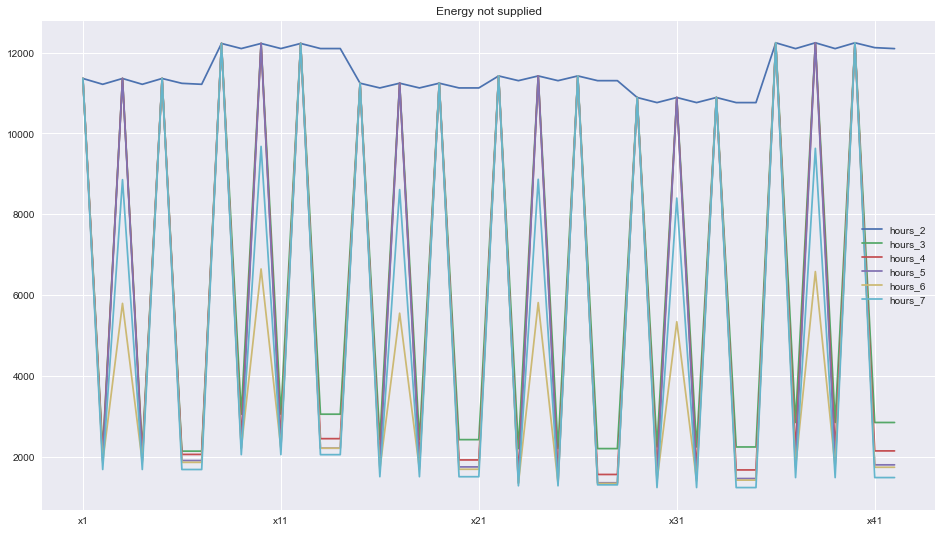

In [157]:
df_E_not_supplied_hours.plot(title="Energy not supplied", figsize = figsize)

<AxesSubplot:title={'center':'Total cost'}, xlabel='Hours for charging'>

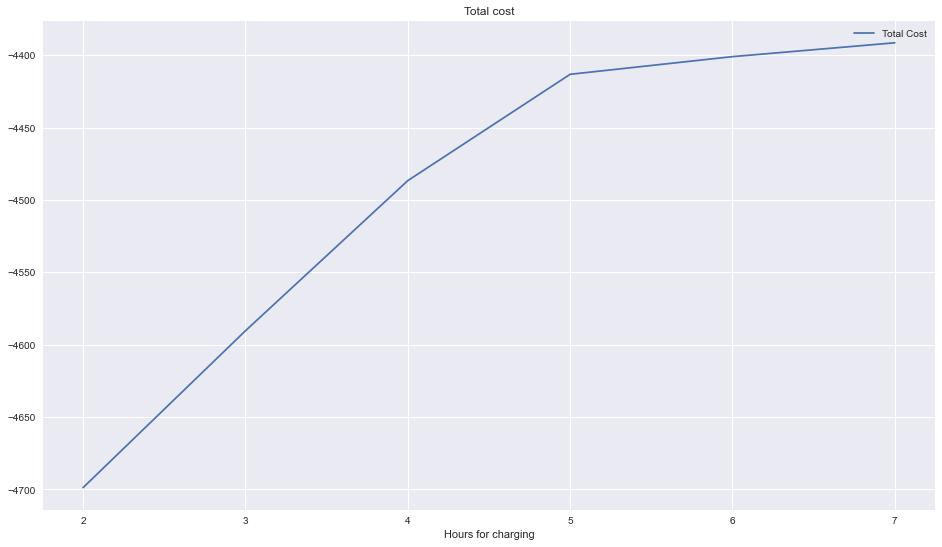

In [24]:
df_cost_hours.plot(title="Total cost", figsize = figsize)

<AxesSubplot:title={'center':'Cvar'}, xlabel='Hours for charging'>

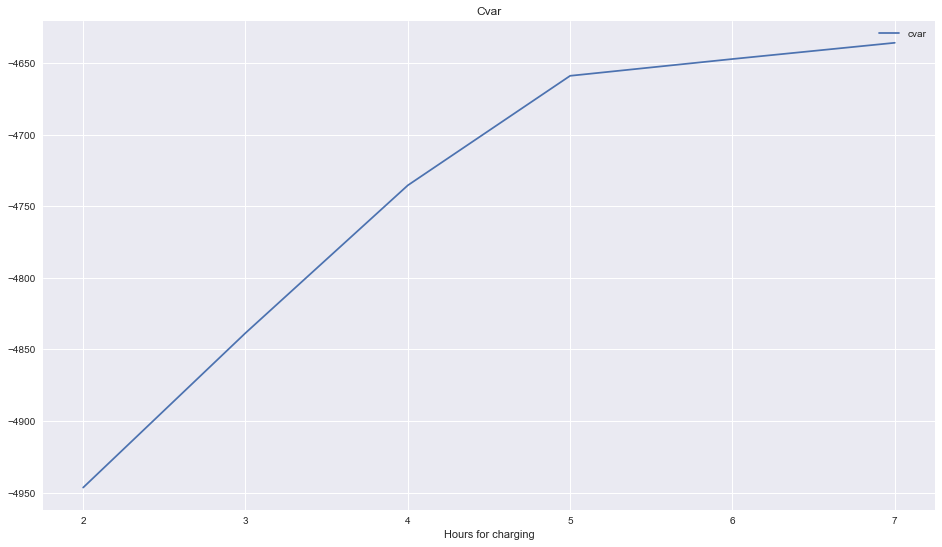

In [25]:
df_cvar_hours.plot(title="Cvar", figsize = figsize)